# Detección y Clasificación del Cáncer de Mama Usando Redes Neuronales Convolucionales: Implementación de Faster R-CNN
____________________________________________________________________________________________________________________

# 1.	Descripción del problema

## 1.1	Contexto del Problema

El cáncer de mama es actualmente la forma más común de cáncer entre las mujeres a nivel mundial y una de las principales causas de mortalidad. Según un estudio reciente publicado por la Agencia Internacional para la Investigación del Cáncer (IARC) [1], se estima que una de cada veinte mujeres será diagnosticada con esta enfermedad a lo largo de su vida. Las proyecciones indican que, si las tendencias actuales se mantienen, para el año 2050 habrá 3.2 millones de nuevos casos anuales y 1.1 millones de muertes asociadas. Aunque la incidencia es mayor en países con alto índice de desarrollo humano, la mortalidad afecta de manera desproporcionada a regiones con menos recursos, debido a las limitaciones en el acceso a diagnóstico temprano y tratamiento adecuado. Frente a este panorama, mejorar las herramientas de detección temprana, como el análisis automatizado de mamografías, se vuelve esencial para reducir la carga global de esta enfermedad.

## 1.2	Conjunto de Datos

El conjunto de datos *VinDr-Mammo* [2] es un benchmark a gran escala compuesto por **5,000 estudios** de mamografía de campo digital completo (FFDM), recolectados en Vietnam y publicado en 2022. Cada estudio incluye cuatro vistas estándar *(CC y MLO de ambas mamas)*, sumando un total de **20,000 imágenes**. El dataset proporciona anotaciones clínicas detalladas que incluyen *evaluaciones BI-RADS* y *densidad mamaria* (categorías A–D) a nivel de mama, así como hallazgos no benignos (BI-RADS > 2) como *masas*, *calcificaciones*, *asimetrías*, *distorsiones arquitectónicas*, y otras características asociadas, delimitados mediante cajas rectangulares. Las anotaciones están estructuradas y disponibles en archivos CSV, lo que facilita su uso en tareas de detección de objetos, clasificación múltiple y entrenamiento de modelos de diagnóstico asistido por computadora (CADe/x) en imágenes mamográficas.

## 1.3	Objetivo General

Implementar un modelo Faster R-CNN para detectar y clasificar hallazgos mamográficos relacionados con cáncer de mama usando el conjunto de datos VinDr-Mammo.

## 1.4	Objetivos Específicos

- Analizar y preparar el conjunto de datos VinDr-Mammo para el entrenamiento.
- Preprocesar y adaptar las imágenes y anotaciones para el modelo.
- Entrenar y ajustar el modelo Faster R-CNN con los datos preparados.
- Evaluar el rendimiento del modelo con métricas estándar.
- Analizar la utilidad del modelo como herramienta para diagnóstico temprano y proponer mejoras futuras.

____________________________________________________________________________________________________________________

# 2.	Exploración y análisis inicial del conjunto de datos VinDr-Mammo

## 2.1. Inspección inicial de los datos

Empezamos analizando el contenido del archivo 'finding_annotations.csv' que contiene información acerca de los hallazgos del conjunto de datos VinDr-Mammo. Iniciamos convirtiendo el archivo en un formato de diccionario de Python, posteriormente filtrando las imágenes que contienen los hallazgos de interés.

In [1]:
import csv
from collections import defaultdict

def csv_to_nested_dict(csv_path, key1, key2):
    nested_dict = defaultdict(dict)
    with open(csv_path, newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            k1 = row[key1]
            k2 = row[key2]
            nested_dict[k1].setdefault(k2, [])
            nested_dict[k1][k2].append(row)
    return dict(nested_dict)

annotations = csv_to_nested_dict("pim/finding_annotations.csv", "study_id", "image_id")

## 2.1.1. Distribución de categorías en general

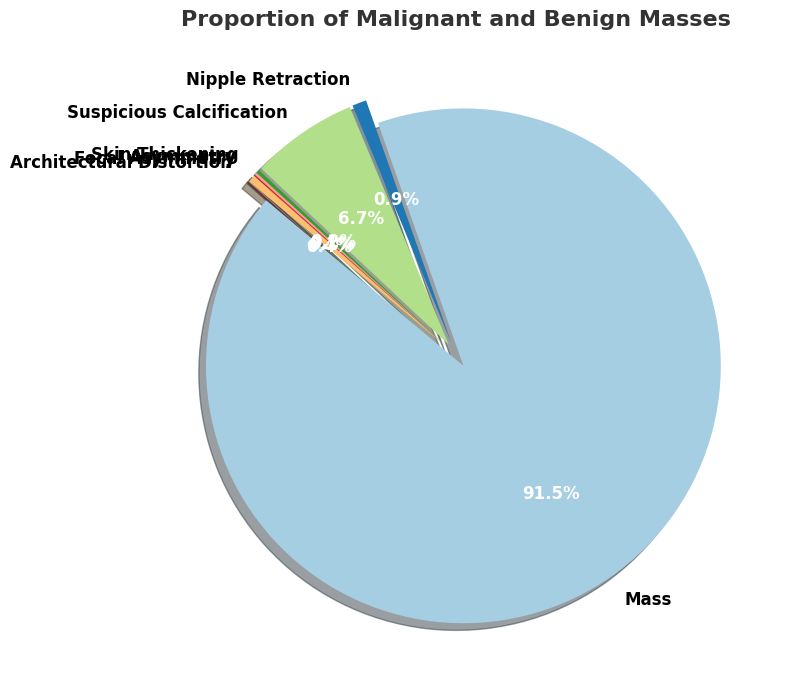

In [33]:
def plot_pie_chart(labels, values, title):
    if not labels or not values or len(labels) != len(values):
        raise ValueError("Se requieren listas válidas de etiquetas y valores del mismo tamaño.")
    
    colors = plt.cm.Paired(range(len(values)))
    
    explode = [0.05] * len(values)

    fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')

    wedges, texts, autotexts = ax.pie(
        values,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        explode=explode,
        shadow=True,
        textprops=dict(color="black", fontsize=12, fontweight='bold')
    )

    # Estilo del centro
    ax.set_title(title, fontsize=16, fontweight='bold', color='#333')
    plt.setp(autotexts, size=12, weight="bold", color="white")

    plt.tight_layout()
    plt.show()


def count_categories(nested_dict, catkey, categories):
    catcount = {}
    for k1, inner in nested_dict.items():
        for k2, innerlist in inner.items():
            for elem in innerlist:
                catval = elem.get(catkey, None)
                if catval is None:
                    continue
                for category in categories:
                    if category in catval:
                        catcount.setdefault(category, 0)
                        catcount[category] += 1
    return catcount

categories = ['Mass', 'Nipple Retraction', 'Suspicious Calcification', 'Skin Thickening', 'Asymmetry', 'Focal Asymmetry', 'Architectural Distortion']
counts = count_categories(annotations, "finding_categories", categories)

counts_parted = [v for k, v in counts.items()]
counts_categs = [k for k, v in counts.items()]

plot_pie_chart(counts_categs, counts_parted, title="Proportion of Malignant and Benign Masses")

## 2.2. Filtrado de imágenes sin masas
En nuestro estudio nos enfocaremos en las imágenes que contienen masas. Las filtramos mediante la columna 'finding_categories', solo las contienen la cadena 'Mass'.

In [2]:

def filter_nested_dict_by_value(nested_dict, key_filter, substring):
    result = {}
    for k1, inner in nested_dict.items():
        filtered_inner = {}

        for k2, v_list in inner.items():
            filtered_v_list = [
                item for item in v_list
                if key_filter in item and substring in str(item[key_filter])
            ]

            if filtered_v_list:
                filtered_inner[k2] = filtered_v_list

        if filtered_inner:
            result[k1] = filtered_inner

    return result

annotations = filter_nested_dict_by_value(annotations, "finding_categories", "'Mass'")

584


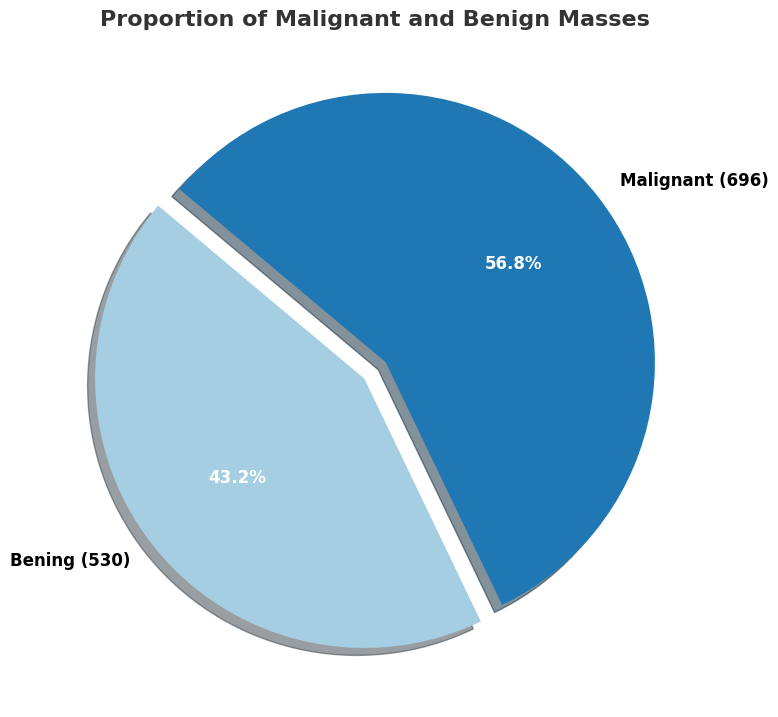

In [4]:
import matplotlib.pyplot as plt

def count_condition_matches(nested_dict, key, substrings):
    matches = 0
    substrings = set(substrings) 

    for inner in nested_dict.values():
        for subdict in inner.values():
            for elem in subdict:
                if any(sub in elem.get(key, '') for sub in substrings):
                    matches += 1

    return matches
 
bening = count_condition_matches(annotations, 'breast_birads', ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3'])
malignant = count_condition_matches(annotations, 'breast_birads', ['BI-RADS 4', 'BI-RADS 5', 'BI-RADS 6'])

plot_pie_chart([f'Bening ({bening})', f'Malignant ({malignant})'], [bening, malignant], title="Proportion of Malignant and Benign Masses")

____________________________________________________________________________________________________________________________________________________

# 3.	Preprocesamiento de Datos

La preparación de las imágenes explica un paso esencial para garantizar que los datos de entrada sean consistentes, de alta calidad y adecuados para el entrenamiento de modelos de detección. Este proceso ayuda a que las imágenes médicas preserven la relevancia clínica de las características visuales clave, optimizando el potencial diagnóstico del modelo entrenado. Es por eso que las siguientes estrategias fueron escogidas rigurosamente para el buen tratado y manejo óptimo de los datos: 

-	**Conversión de formato DICOM a matriz NumPy:** Se extraen los datos del archivo DICOM y se convierten a un arreglo float32 para permitir operaciones matemáticas posteriores.
-	**Transformación logaritmica:** Se aplica una escala logarítmica a los valores de píxeles para mejorar la visibilidad de estructuras sutiles y facilitar tareas de segmentación.
-	**Segmentación por bordes (Canny + cierre morfológico):** Se detectan los bordes con el algoritmo de Canny, se cierran las discontinuidades morfológicamente y se selecciona el contorno más grande como región de interés (ROI).
-	**Recorte de regiones no nulas:** e recorta automáticamente la imagen para eliminar áreas negras sin información, dejando únicamente la región útil detectada.
-	**Windowing o Intensity Clipping and Rescaling:** aSe ajusta el rango dinámico de la imagen para destacar intensidades relevantes (entre el valor mínimo no nulo y el máximo), remapeando a una escala de 0–255.
-	**Merged CLAHE enhancement** Aplica CLAHE con diferentes parámetros y fusiona los resultados para lograr un contraste más equilibrado.

## 3.1. Implementación del preprocesamiento


In [3]:
import pydicom
import numpy as np
import cv2
from skimage import exposure
import matplotlib.pyplot as plt


def load_dicom_image(path):
    dicom = pydicom.dcmread(path)
    out_image = dicom.pixel_array.astype(np.float32)
    return out_image

def contour_area_with_logging(contour):
    area = cv2.contourArea(contour)
    return area
    
def segment_by_edges(in_image: np.ndarray, low_threshold=100, high_threshold=230):

    # "Enmarca" la imagen para encontrar los contornos abiertos
    padded = cv2.copyMakeBorder(in_image, 1, 1, 1, 1, cv2.BORDER_CONSTANT)

    # Canny edge detection
    _edges = cv2.Canny(padded, low_threshold, high_threshold)

    # Al haber discontinuidad en los bordes, se usa esta función para obtener de mejor forma el área de la mama
    kernel = np.ones((3, 3), np.uint8)
    _edges_closed = cv2.morphologyEx(_edges, cv2.MORPH_CLOSE, kernel)

    # Encontrar contornos exteriores
    _contours, _ = cv2.findContours(_edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if not _contours:
        raise ValueError("No se encontraron contornos.")

    # Encontrar el contorno con mayor área
    largest_contour = max(_contours, key=contour_area_with_logging)

    # Crear máscara y rellenar contorno
    final_mask = np.zeros_like(padded, dtype=np.uint8)
    cv2.drawContours(final_mask, [largest_contour], -1, color=255, thickness=-1)

    # Quitar el padding antes de devolver (recorta el borde)
    h, w = in_image.shape
    final_mask = final_mask[1:h+1, 1:w+1]

    return final_mask, _edges[1:h + 1, 1:w + 1], largest_contour

def crop_nonzero(image, study_id, image_id):
    mask = image != 0

    coords = np.argwhere(mask)

    if coords.size == 0:
        return np.zeros((0,0), dtype=image.dtype) if image.ndim == 2 else np.zeros((0,0,image.shape[2]), dtype=image.dtype)

    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1

    cropped_image = image[y0:y1, x0:x1] if image.ndim == 2 else image[y0:y1, x0:x1, :]

    return cropped_image, x0, y0

def apply_windowing(image: np.ndarray) -> np.ndarray:
    pixels = image.flatten()
    pixels_nonzero = pixels[pixels > 0]

    lower_bound = np.min(pixels_nonzero)
    upper_bound = np.max(pixels)

    # Aplicar windowing con clamping
    clipped = np.clip(image, lower_bound, upper_bound)

    # Escalar a 0-255
    width = upper_bound - lower_bound
    scaled = (clipped - lower_bound) / (width if width > 0 else 1) * 255
    windowed_image = scaled.astype(np.uint8)

    return windowed_image

def enhance_contrast_clahe(image, clip_limit=3.0, tile_grid_size=(8, 8)):
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    enhanced = clahe.apply(image)
    
    return enhanced

def enhance_contrast_clahe_merged(image):
    image = image.astype(np.uint8)

    clahe1 = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8)).apply(image).astype(np.float32)
    clahe2 = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8)).apply(image).astype(np.float32)
    clahe3 = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8)).apply(image).astype(np.float32)

    # Normalizar para fusionar
    clahe1 /= 255.0
    clahe2 /= 255.0
    clahe3 /= 255.0

    # Pesos para fusionar, ajustables
    merged = (0.3 * clahe1 + 0.4 * clahe2 + 0.3 * clahe3)

    merged = np.clip(merged * 255.0, 0, 255).astype(np.uint8)
    return merged
    
def preprocess(in_image, study_id, image_id, visualize=False):
    image = load_dicom_image(in_image)

    delta = np.ptp(image)
    c = delta / np.log(delta)
    log = c * np.log(1 + image)

    image_norm = exposure.rescale_intensity(log, out_range=(0, 255)).astype(np.uint8)

    mask, edges, contours = segment_by_edges(image_norm)

    segmented_image, x0, y0 = crop_nonzero(image * mask, study_id, image_id)

    windowed_image = apply_windowing(segmented_image)

    windowed_norm = exposure.rescale_intensity(windowed_image, out_range=(0, 255)).astype(np.uint8)

    enhanced_contrast = enhance_contrast_clahe_merged(windowed_norm)

    if visualize:
        visualize_segmentation_with_edges(image, edges, mask, segmented_image, windowed_image, enhanced_contrast)
        show_histogram(enhanced_contrast, "Image Histogram")
        show_histogram(enhanced_contrast[enhanced_contrast > 5], "Image Histogram without low values")

    return enhanced_contrast, x0, y0

def visualize_segmentation_with_edges(image, edges, mask, segmented, windowed, enhanced):
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    axs[0][0].imshow(image, cmap='gray')
    axs[0][0].set_title("Original DICOM")
    axs[0][0].axis('off')

    axs[0][1].imshow(edges, cmap='gray')
    axs[0][1].set_title("Canny Edges")
    axs[0][1].axis('off')

    axs[0][2].imshow(mask, cmap='gray')
    axs[0][2].set_title("Segmented Mask using Canny Edges")
    axs[0][2].axis('off')

    axs[1][0].imshow(segmented, cmap='gray')
    axs[1][0].set_title("Segmented Image")
    axs[1][0].axis('off')

    axs[1][1].imshow(windowed, cmap='gray')
    axs[1][1].set_title("Windowed Image using Min and Max Values")
    axs[1][1].axis('off')

    axs[1][2].imshow(enhanced, cmap='gray')
    axs[1][2].set_title("Enhanced contrast with CLAHE")
    axs[1][2].axis('off')

    plt.tight_layout()
    plt.show()

def show_histogram(image, title="Image Histogram"):
    image_flat = image.ravel()

    plt.figure(figsize=(8, 4))
    plt.hist(image_flat, bins=256, color='slateblue', alpha=0.85, edgecolor='black')
    plt.title(title)
    plt.xlabel("Intensity value")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


import os
from PIL import Image
from concurrent.futures import ProcessPoolExecutor
from functools import partial

def process_and_save(case):
    study_id = case["study_id"]
    image_id = case["image_id"]
    dicom_path = f'pim/filtered/{study_id}/{image_id}.dicom'
    output_path = f'pim/preprocessed/{study_id}/{image_id}.png'

    try:
        image, x0, y0 = preprocess(dicom_path, study_id, image_id)

        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        img_pil = Image.fromarray(image)
        img_pil.save(output_path)

        return x0, y0
    except Exception as e:
        print(f"Error en {dicom_path}: {e}")

def run_parallel_processing(annotations):
    cases = []
    for study in annotations.values():
        for images in study.values():
            cases.extend(images)

    results = []

    with ProcessPoolExecutor() as executor:
        for result in executor.map(process_and_save, cases):
            results.append(result)
            
    return zip(cases,results)

## 3.2. Visualización del Preprocesamiento

Revisaremos dos imágenes para hacer un seguimiento del preprocesamiento aplicado previamente. Esta etapa es esencial para asegurar la calidad del conjunto de datos y la validez del flujo de trabajo de detección.

,image_id,finding_categories,finding_birads,breast_density
0,33cfef605778cd250f653662ab876afb,['Mass'],BI-RADS 5,DENSITY B


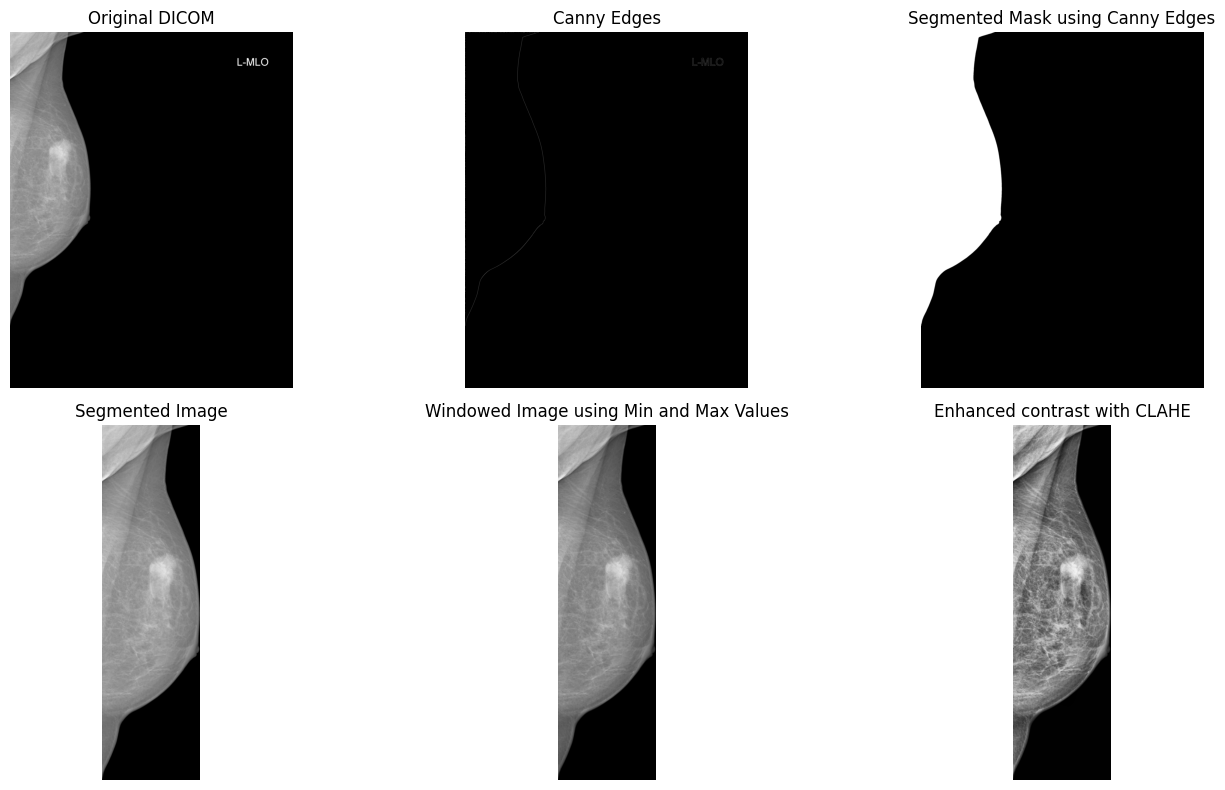

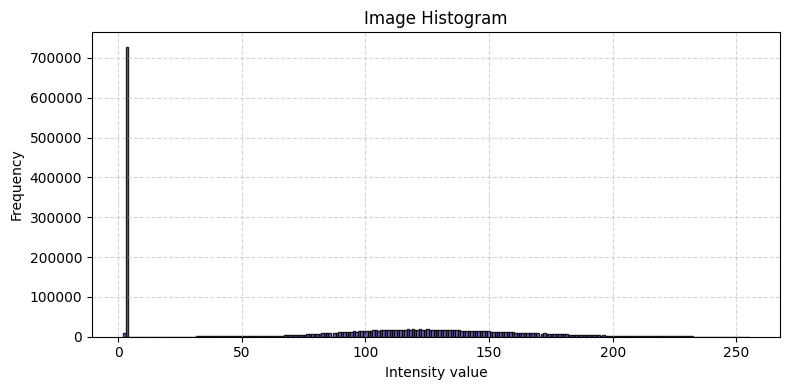

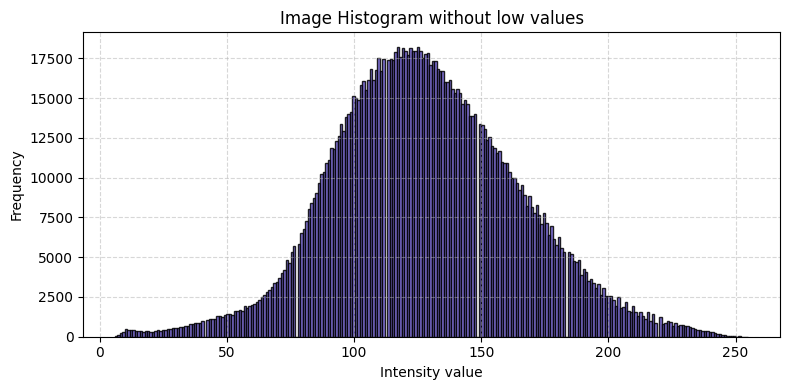

PROCESS STARTED
******************** FASTER R-CNN model evaluation process started... ********************
load checkpoint from local path: /home/cbddobvyz/workspace/models/fasterrcnn.pth
--> Applying Non Maximum Suppression to model predicts...
[ 335.14599609 1014.80999756  660.15698242 1469.83996582]
[ 139.84301758 1014.80999756  464.85400391 1469.83996582]
[ 335.14599609 1433.16003418  660.15698242 1888.19000244]
[ 139.84301758 1433.16003418  464.85400391 1888.19000244]
-*- ELAPSED PROCESSING TIME: 4 seconds -*-


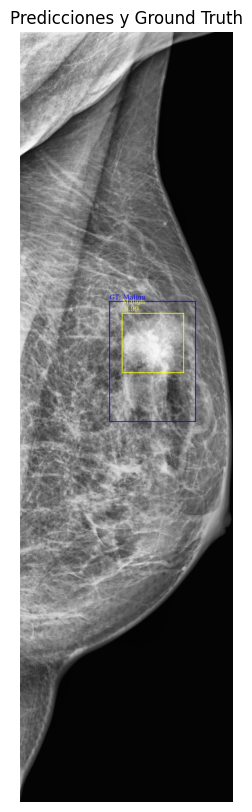

,image_id,finding_categories,finding_birads,breast_density
0,fb413cf6ef972090326d9886fa500aa2,['Mass'],BI-RADS 3,DENSITY C


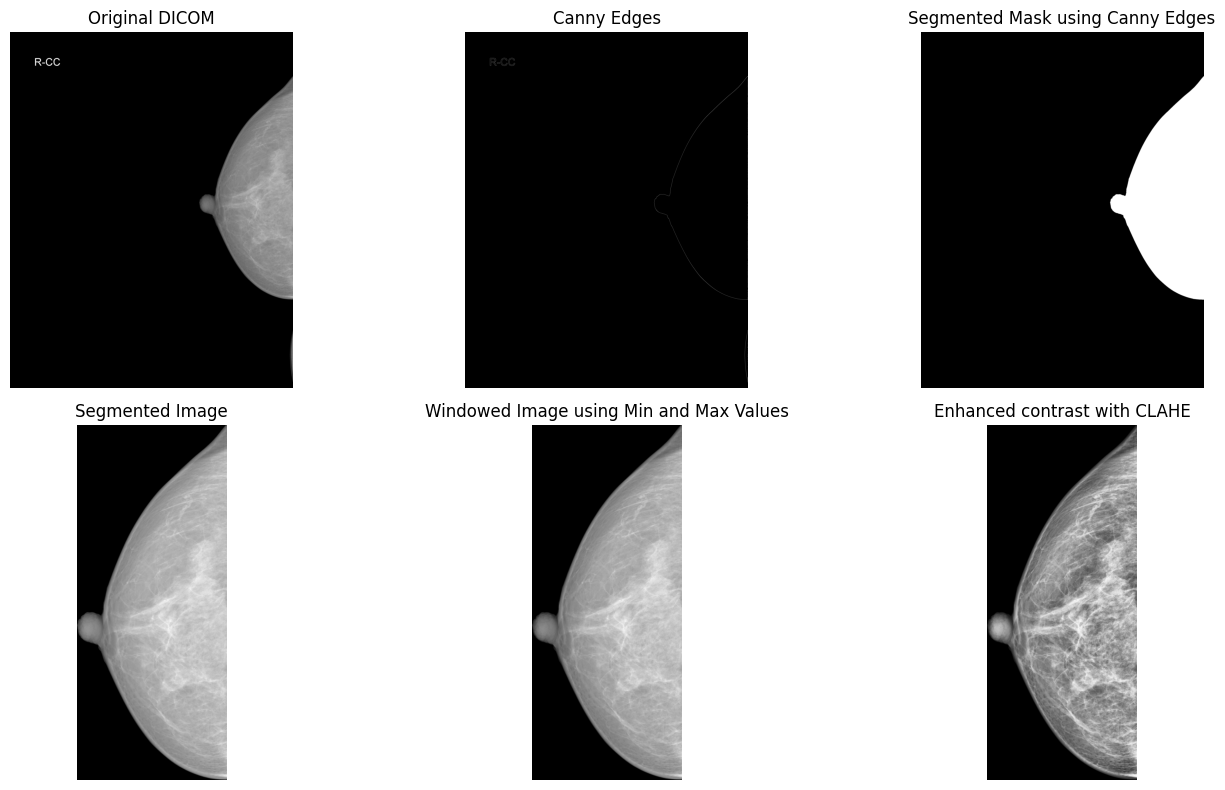

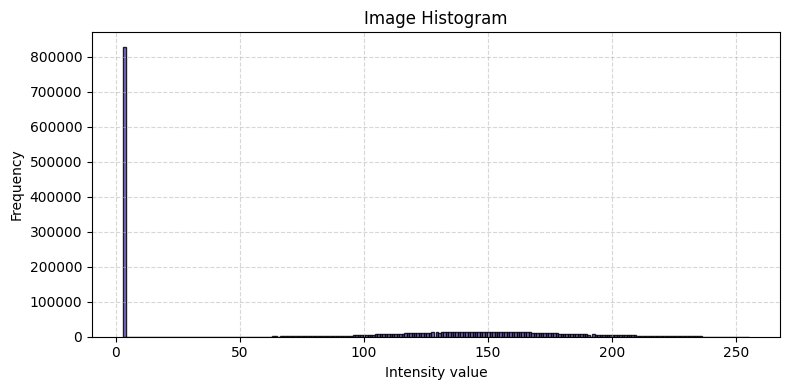

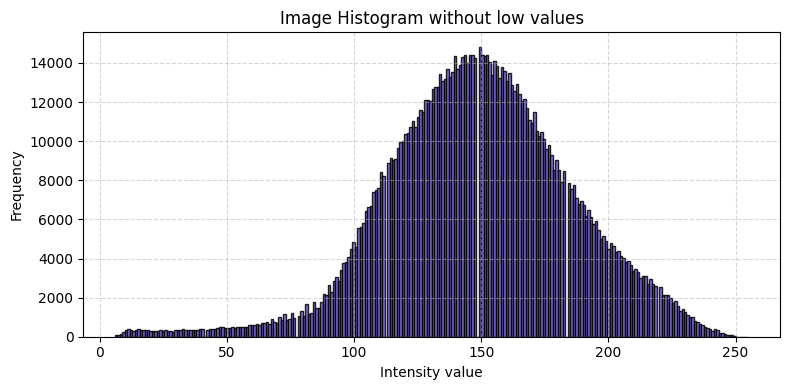

PROCESS STARTED
******************** FASTER R-CNN model evaluation process started... ********************
load checkpoint from local path: /home/cbddobvyz/workspace/models/fasterrcnn.pth
--> Applying Non Maximum Suppression to model predicts...
[ 456.37011719 1128.04003906  670.         1290.9699707 ]
[ 259.         1128.04003906  472.62988281 1290.9699707 ]
[ 456.37011719  918.0300293   670.         1080.95996094]
[ 259.          918.0300293   472.62988281 1080.95996094]
-*- ELAPSED PROCESSING TIME: 5 seconds -*-


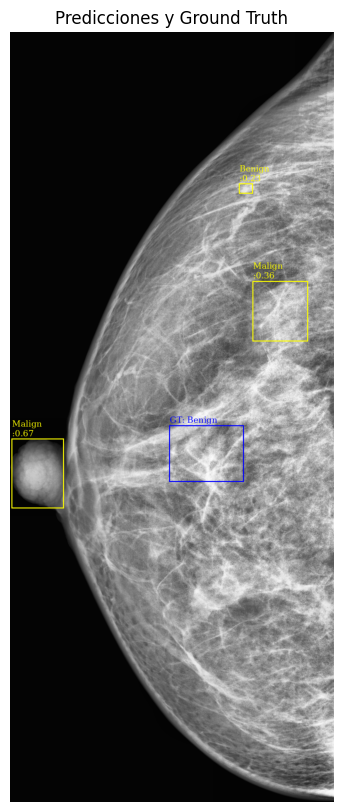

In [6]:
import pandas as pd
from PIL import Image
from IPython.display import display

from eval import eval_with_faster_rcnn

import copy

sample_cases = [
    ("5d99bedc43c3225261b270fa4bc5181c", "33cfef605778cd250f653662ab876afb"),
    ("882d6a7db05470e51f85f3c77b217945", "fb413cf6ef972090326d9886fa500aa2")
]

for sample_study, sample_image_id in sample_cases:
    sample_case = annotations[sample_study][sample_image_id]
    df = pd.DataFrame(sample_case, columns=['image_id', 'finding_categories', 'finding_birads', 'breast_density'])
    display(df)

    path = f"pim/filtered/{sample_study}/{sample_image_id}.dicom"

    enhanced, x0, y0 = preprocess(path, sample_study, sample_image_id, visualize=True)

    copied = copy.deepcopy(sample_case)
    
    for finding in copied:
        finding["xmin"] = float(finding["xmin"]) - x0
        finding["ymin"] = float(finding["ymin"]) - y0
        finding["xmax"] = float(finding["xmax"]) - x0
        finding["ymax"] = float(finding["ymax"]) - y0

    sub_annotations = {
        sample_study: {
            sample_image_id: copied
        }
    }

    eval_with_faster_rcnn(sub_annotations, augment=True)

    image = Image.open(f'results/annotated/{sample_image_id}.png')
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Predicciones y Ground Truth")
    plt.show()


## 3.3. Preparación del modelo 
El modelo de detección de masas mamográficas implementado en este proyecto se basa en la arquitectura Faster R-CNN[3], extraída y adaptada del estudio de Terzi et al. (2024), titulado "The digital eye for mammography: deep transfer learning and model ensemble based open-source toolkit for mass detection and classification"[4]. Este trabajo presenta una herramienta de código abierto, DEM (Digital Eye for Mammography), que integra 11 arquitecturas de detección de objetos de última generación, incluyendo Faster R-CNN, para la detección y clasificación de masas en mamografías.

Para este proyecto, se extrajo específicamente la implementación de Faster R-CNN del repositorio de DEM[4] y se reorganizó su estructura para adaptarla a los objetivos del estudio. Las modificaciones incluyeron ajustes en el preprocesamiento de imágenes, adaptación de las anotaciones al formato del conjunto de datos VinDr-Mammo y la incorporación de técnicas de aumento de datos. Estas adaptaciones permitieron enfocar el modelo en la detección y clasificación de hallazgos mamográficos específicos, alineándose con los objetivos planteados en este trabajo.3

In [7]:
results = run_parallel_processing(annotations)

In [8]:
#results = list(results)
#print([_ for _, coords in results])
def update_and_save_annotations(results):
    for cases, coords in results:
        x0, y0 = coords
        for case_ in annotations[cases["study_id"]][cases["image_id"]]:
            case_["xmin"] = float(case_["xmin"]) - x0
            case_["ymin"] = float(case_["ymin"]) - y0
            case_["xmax"] = float(case_["xmax"]) - x0
            case_["ymax"] = float(case_["ymax"]) - y0

    import json

    with open('annotations.json', 'w') as f:
        json.dump(annotations, f, indent=4)

#update_and_save_annotations(results)

In [ ]:
import json
from eval import eval_with_faster_rcnn

with open('annotations.json', 'r') as f:
    annotations = json.load(f)

#results, bests_ious = eval_with_faster_rcnn(annotations, augment=True, device='cuda', confidence_threshold=0.4, ap_threshold=0.1, nms_iou_threshold=0.1)

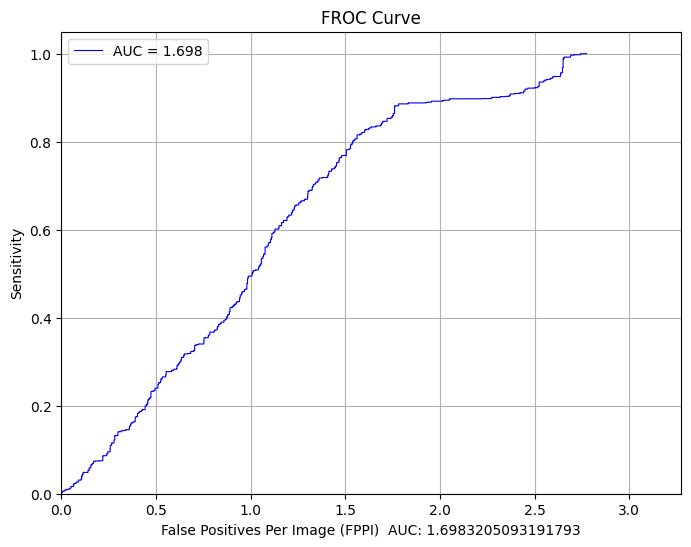

1.6983205093191793

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_froc_curve_from_ious(ious, num_images, title='FROC Curve'):
    """
    Dibuja una curva FROC basada en IoUs de predicciones y calcula el AUC.
    
    Args:
        ious: Lista de IoUs de predicciones. Valores > 0 son verdaderos positivos, 0 son falsos positivos.
        num_images: Número total de imágenes evaluadas.
        title: Título del gráfico.
        
    Returns:
        auc: Área bajo la curva FROC.
    """
    ious = np.array(ious)
    is_tp = ious > 0
    is_fp = ious == 0

    # Recorremos predicciones acumulando TPs y FPs
    tps = np.cumsum(is_tp)
    fps = np.cumsum(is_fp)

    total_positives = np.sum(is_tp)
    sensitivity = tps / total_positives if total_positives > 0 else np.zeros_like(tps)
    fppi = fps / num_images

    # Calcular AUC usando integración numérica
    auc = np.trapz(sensitivity, fppi)

    # Graficar
    plt.figure(figsize=(8, 6))
    plt.plot(fppi, sensitivity, linewidth=0.8, color='blue', label=f'AUC = {auc:.3f}')
    plt.xlabel(f'False Positives Per Image (FPPI)  AUC: {auc}')
    plt.ylabel('Sensitivity')
    plt.title(title)
    plt.grid(True)
    plt.xlim([0, max(fppi) + 0.5])
    plt.ylim([0, 1.05])
    plt.legend()
    plt.show()
    
    return auc

def plot_roc_curve_from_ious(ious, title='ROC Curve'):
    ious = np.array(ious)
    labels = (ious > 0).astype(int)  # 1 = TP, 0 = FP

    # Usamos el valor de IoU como puntaje para el clasificador
    scores = ious.copy()

    thresholds = np.linspace(0, scores.max(), num=100)
    tpr_list = []
    fpr_list = []

    for thresh in thresholds:
        predicted_positive = scores >= thresh
        tp = np.sum((predicted_positive == 1) & (labels == 1))
        fp = np.sum((predicted_positive == 1) & (labels == 0))
        fn = np.sum((predicted_positive == 0) & (labels == 1))
        tn = np.sum((predicted_positive == 0) & (labels == 0))

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    # Ordenamos FPR y TPR por FPR para el cálculo del AUC
    fpr_list, tpr_list = zip(*sorted(zip(fpr_list, tpr_list)))
    auc_score = auc(fpr_list, tpr_list)

    # Graficar
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_list, tpr_list, color='darkorange', lw=2, label=f'AUC = {auc_score:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()

    return auc_score

num_images = 0
for study_id, study_val in annotations.items():
    for image_id, image_val in study_val.items():
        num_images += 1

#plot_roc_curve_from_ious(bests_ious)
plot_froc_curve_from_ious(bests_ious, num_images)

### Análisis y conclusiones de la gráfica:
> La curva FORC (Free-REspone Receiver Operating Characteristics), que se usa comúnmente para evaluar el rendimiento de modelos de detección en imágenes médicas
>
> Eje Y (sensibilidad): Capacidad del modelo para detectar verdaderos positivos
> Eje X (FFPI: False Positive Per Image): Cuántas veces el modelo predice algo incorrectamente por imagen.
>
> Conclusiones
> 1. Sensibilidad relativamente baja en general:
	•	La curva se eleva lentamente y no llega al 100% de sensibilidad.
	•	Esto indica que el modelo no logra detectar todos los verdaderos positivos, incluso permitiendo varios falsos positivos por imagen.
> 2.	Rendimiento limitado ante incremento de FPPI:
	•	Incluso cuando se toleran más falsos positivos por imagen (hasta 3), la sensibilidad no llega a 1.0.
	•	Esto puede indicar que el modelo Digital Eye tiene dificultad para identificar todas las lesiones en las mamografías.
> 3.	Curva no demasiado empinada al inicio:
	•	Un buen modelo suele tener una curva empinada al inicio, mostrando que alcanza alta sensibilidad con pocos falsos positivos.
	•	Aquí la curva sube de manera más gradual, lo que sugiere un desempeño subóptimo.

_______________________________________________________________________________________________________________________________________________________

# 4. Análisis de resultados

Detectamos un bajo rendimiento del modelo Digital eye sobre el conjunto de datos de VinDr 
_______________________________________________________________________________________________________________________________________________________

# 5. Conclusión



## 5.1. Limitaciones

- Alcance limitado de detección:
El modelo implementado se enfoca únicamente en la detección de masas clasificadas como benignas o malignas. No contempla otros tipos de hallazgos mamográficos relevantes como distorsiones arquitectónicas, calcificaciones u otros patrones presentes en estudios clínicos más amplios.

- Dependencia de una arquitectura preexistente:
Aunque se utilizó la arquitectura Faster R-CNN como base, esta fue extraída del trabajo “The Digital Eye for Mammography”. Debido a restricciones de tiempo y recursos, no se tuvo un acceso completo ni profundo a la totalidad del toolkit, lo cual limitó una comprensión exhaustiva del comportamiento conjunto de las redes en su forma original.

- No se entrenó desde cero:
El modelo no fue entrenado completamente desde cero. Se usaron pesos preentrenados y una estructura base ya definida, lo cual reduce la flexibilidad para optimizar completamente la arquitectura a las características específicas del conjunto VinDr-Mammo.

- Aumento de datos limitado:
Solo se emplearon técnicas básicas de aumento de datos como el volteo horizontal. Existen otras estrategias efectivas (rotaciones, escalado, recortes aleatorios, ajuste de brillo o contraste) que no fueron implementadas, lo que pudo limitar la capacidad del modelo para generalizar ante variaciones en nuevas mamografías.

- Reducción del tamaño efectivo de la muestra:
Aunque el conjunto VinDr-Mammo contiene aproximadamente 20,000 imágenes, al filtrar específicamente por la categoría de masas (benignas y malignas), el número de muestras útiles se redujo de forma considerable a cerca de 500 casos. Esta disminución obligó a aplicar técnicas de aumento de datos para compensar la escasez y evitar el sobreajuste del modelo, aunque con un conjunto tan limitado sigue existiendo riesgo de pérdida de generalización.


## 5.2. Trabajos Futuros

- Entrenamiento completo desde cero del modelo Faster R-CNN
Una siguiente etapa natural sería entrenar el modelo completamente desde cero, ajustando cada componente de la arquitectura (backbone, RPN, etc.) al conjunto VinDr-Mammo, sin depender de pesos preentrenados, para lograr una mayor especialización en el dominio mamográfico.

- Extensión a otros tipos de hallazgos mamográficos
Ampliar la capacidad del modelo para detectar y clasificar otras anomalías importantes en mamografías, como calcificaciones, distorsiones arquitectónicas o asimetrías, permitiría una solución más integral para el diagnóstico asistido.

- Implementación de estrategias avanzadas de aumento de datos
Incorporar técnicas más variadas como rotación, escalado, cambios de contraste, desenfoque gaussiano, o incluso augmentación generativa con GANs, podría mejorar significativamente la robustez del modelo en contextos clínicos diversos.

- Validación clínica del modelo con expertos radiólogos
Comparar el desempeño del modelo frente a la interpretación de radiólogos humanos permitiría evaluar su utilidad real como herramienta de apoyo al diagnóstico temprano.
_______________________________________________________________________________________________________________________________________________________

# Referencias

[1] Kim, J., Harper, A., McCormack, V. et al. Global patterns and trends in breast cancer incidence and mortality across 185 countries. Nat Med 31, 1154–1162 (2025). https://doi.org/10.1038/s41591-025-03502-3 

[2] H. T. Nguyen, H. Q. Nguyen, H. H. Pham, K. Lam, L. T. Le, M. Dao, and V. Vu, "VinDr-Mammo: A large-scale benchmark dataset for computer-aided diagnosis in full-field digital mammography," medRxiv, preprint, Mar. 10, 2022. [Online]. Available: https://doi.org/10.1101/2022.03.07.22272009 

[3] S. Ren, K. He, R. Girshick, and J. Sun, “Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks,” arXiv.org, Jun. 04, 2015. https://arxiv.org/abs/1506.01497 

[4] R. Terzi, A. E. Kılıç, G. Karaahmetoğlu, and O. B. Özdemir, “The digital eye for mammography: deep transfer learning and model ensemble based open-source toolkit for mass detection and classification,” Signal Image and Video Processing, vol. 19, no. 1, Dec. 2024, doi: 10.1007/s11760-024-03737-6.